In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random
import seaborn as sns
%matplotlib inline

In [221]:
eeg = pd.read_csv('eeg_standardspreadsheet.csv')
eeg.head()
eeg.shape

(11536, 21)

### Group data at SubjectID + VideoID level, split into Features and Labels:

In [257]:
# using only the self-defined label as the target variable:
labels = eeg[['subjectid', 'videoid', 'self-definedlabel']].groupby(['subjectid', 'videoid']).mean()

# drop the 
features = eeg[[val for val in eeg.columns if val not in ('predefinedlabel', 'self-definedlabel')]]

# subsets of eeg and categorical columns:  
eeg_X = ['subjectid', 'videoid', 'attention', 'meditation', 'raw', 'delta', 'theta', 'alpha1', 'alpha2', 'beta1', 'beta2', 'gamma1', 'gamma2']
cat_X = ['subjectid', 'videoid', 'age', 'ethnicity_Bengali', 'ethnicity_English', 'ethnicity_Han Chinese', 'gender_F', 'gender_M']

# extract features from the eeg related columns:
mns = features[eeg_X].groupby(['subjectid', 'videoid']).mean()
mns.rename(columns = lambda x: x + '_mean', inplace = True)

med = features[eeg_X].groupby(['subjectid', 'videoid']).median()
med.rename(columns = lambda x: x + '_med', inplace = True)

mx  = features[eeg_X].groupby(['subjectid', 'videoid']).max()
mx.rename(columns = lambda x: x + '_max', inplace = True)

mn  = features[eeg_X].groupby(['subjectid', 'videoid']).min()
mn.rename(columns = lambda x: x + '_min', inplace = True)

rng = features[eeg_X].groupby(['subjectid', 'videoid']).max() - features[eeg_X].groupby(['subjectid', 'videoid']).min() 
rng.rename(columns = lambda x: x + '_range', inplace = True)

st_dev = features[eeg_X].groupby(['subjectid', 'videoid']).std()
st_dev.rename(columns = lambda x: x + '_st_dev', inplace = True)

skw = features[eeg_X].groupby(['subjectid', 'videoid']).skew()
skw.rename(columns = lambda x: x + '_skew', inplace = True)

cat = features[cat_X].groupby(['subjectid', 'videoid']).mean()

features_grp = pd.concat([mns, med, mx, mn, rng, st_dev, skw, cat], axis = 1)

features_grp.columns

Index(['attention_mean', 'meditation_mean', 'raw_mean', 'delta_mean',
       'theta_mean', 'alpha1_mean', 'alpha2_mean', 'beta1_mean', 'beta2_mean',
       'gamma1_mean', 'gamma2_mean', 'attention_med', 'meditation_med',
       'raw_med', 'delta_med', 'theta_med', 'alpha1_med', 'alpha2_med',
       'beta1_med', 'beta2_med', 'gamma1_med', 'gamma2_med', 'attention_max',
       'meditation_max', 'raw_max', 'delta_max', 'theta_max', 'alpha1_max',
       'alpha2_max', 'beta1_max', 'beta2_max', 'gamma1_max', 'gamma2_max',
       'attention_min', 'meditation_min', 'raw_min', 'delta_min', 'theta_min',
       'alpha1_min', 'alpha2_min', 'beta1_min', 'beta2_min', 'gamma1_min',
       'gamma2_min', 'attention_range', 'meditation_range', 'raw_range',
       'delta_range', 'theta_range', 'alpha1_range', 'alpha2_range',
       'beta1_range', 'beta2_range', 'gamma1_range', 'gamma2_range',
       'attention_st_dev', 'meditation_st_dev', 'raw_st_dev', 'delta_st_dev',
       'theta_st_dev', 'alpha1_st_d

### Correlations on the Extracted Features:

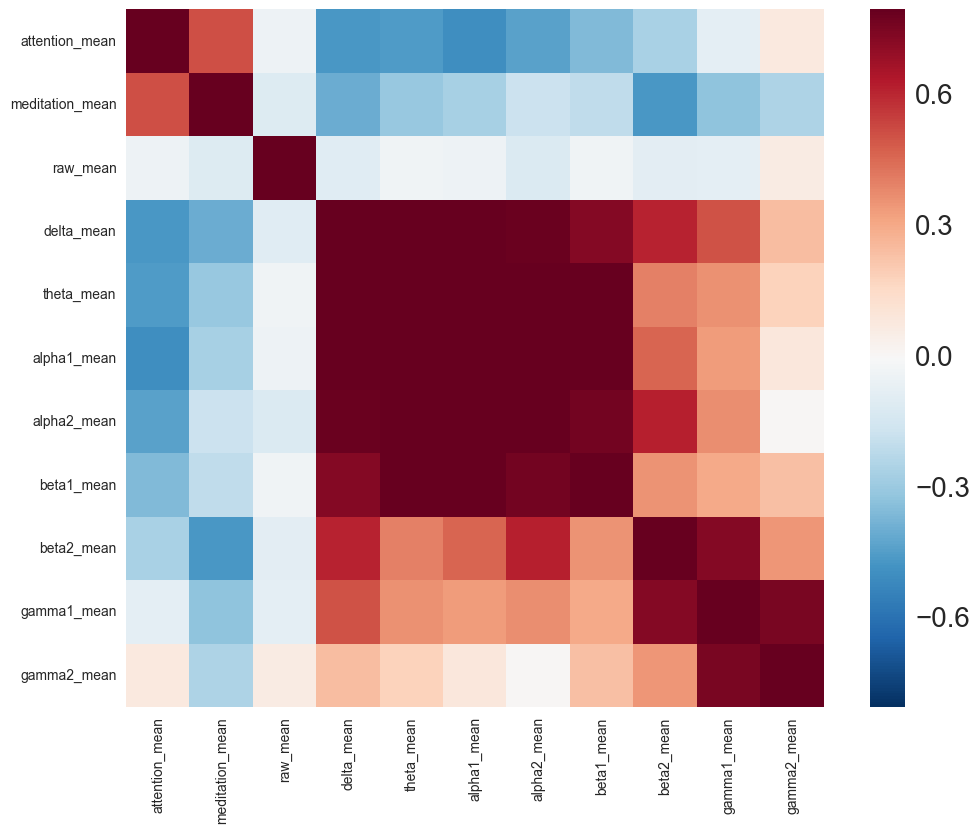

In [27]:
#means:
corrmat = features_grp[mns.columns].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn:
sns.set(font_scale=2)
sns.heatmap(corrmat, vmax=.8, square=True, label = 'large')

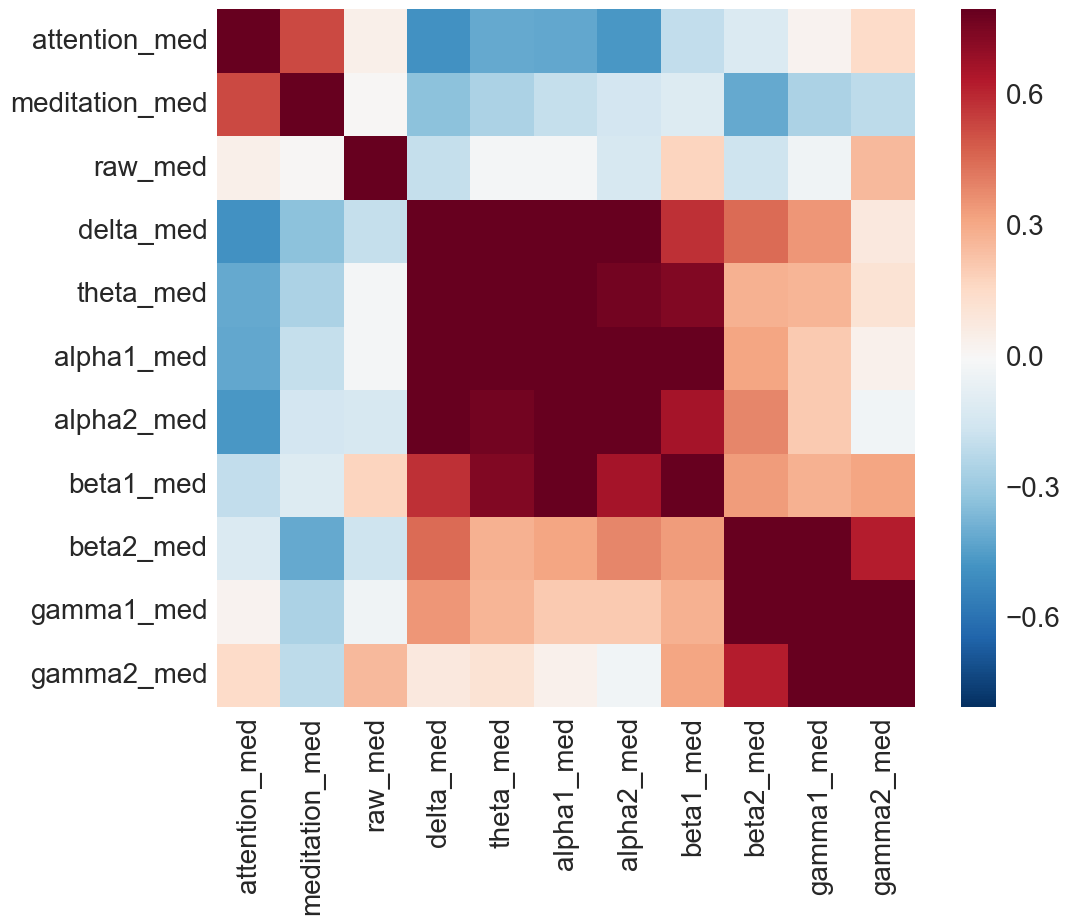

In [28]:
#medians:
corrmat = features_grp[med.columns].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn:
sns.set(font_scale=2)
sns.heatmap(corrmat, vmax=.8, square=True, label = 'large')

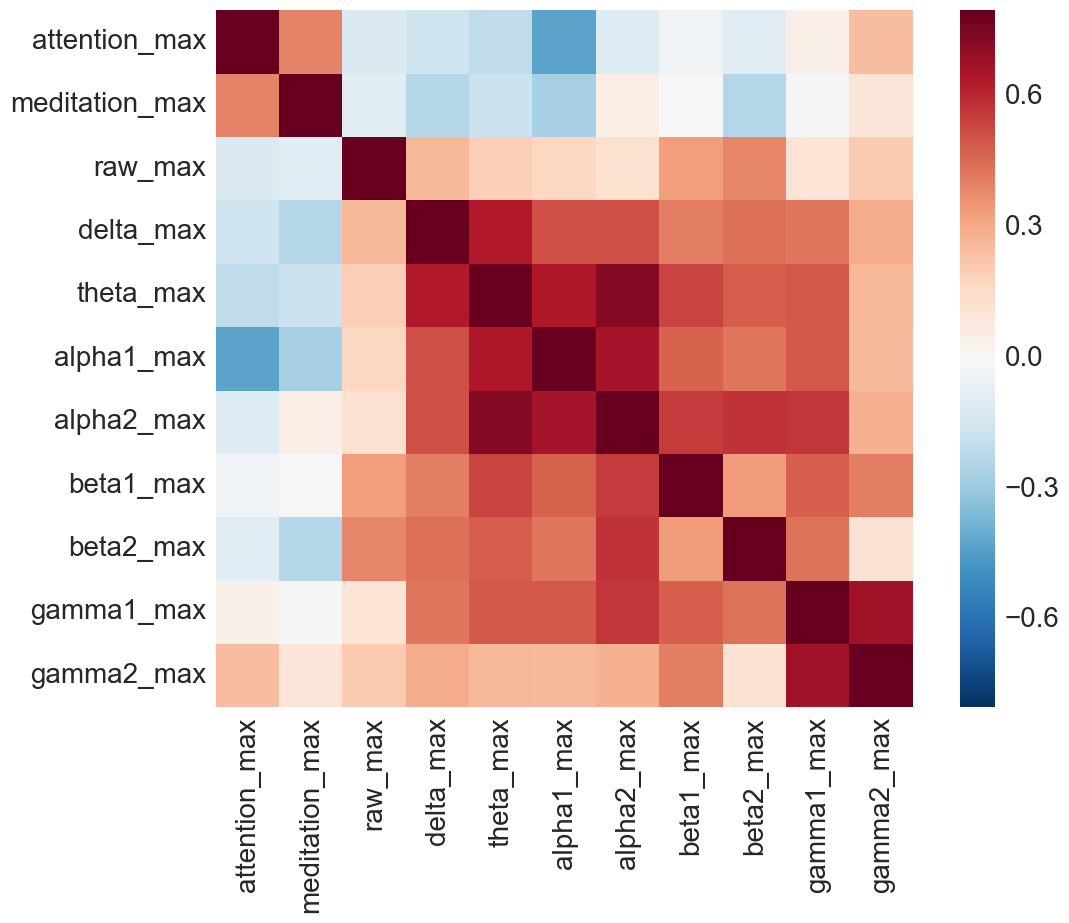

In [29]:
#max:
corrmat = features_grp[mx.columns].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn:
sns.set(font_scale=2)
sns.heatmap(corrmat, vmax=.8, square=True, label = 'large')

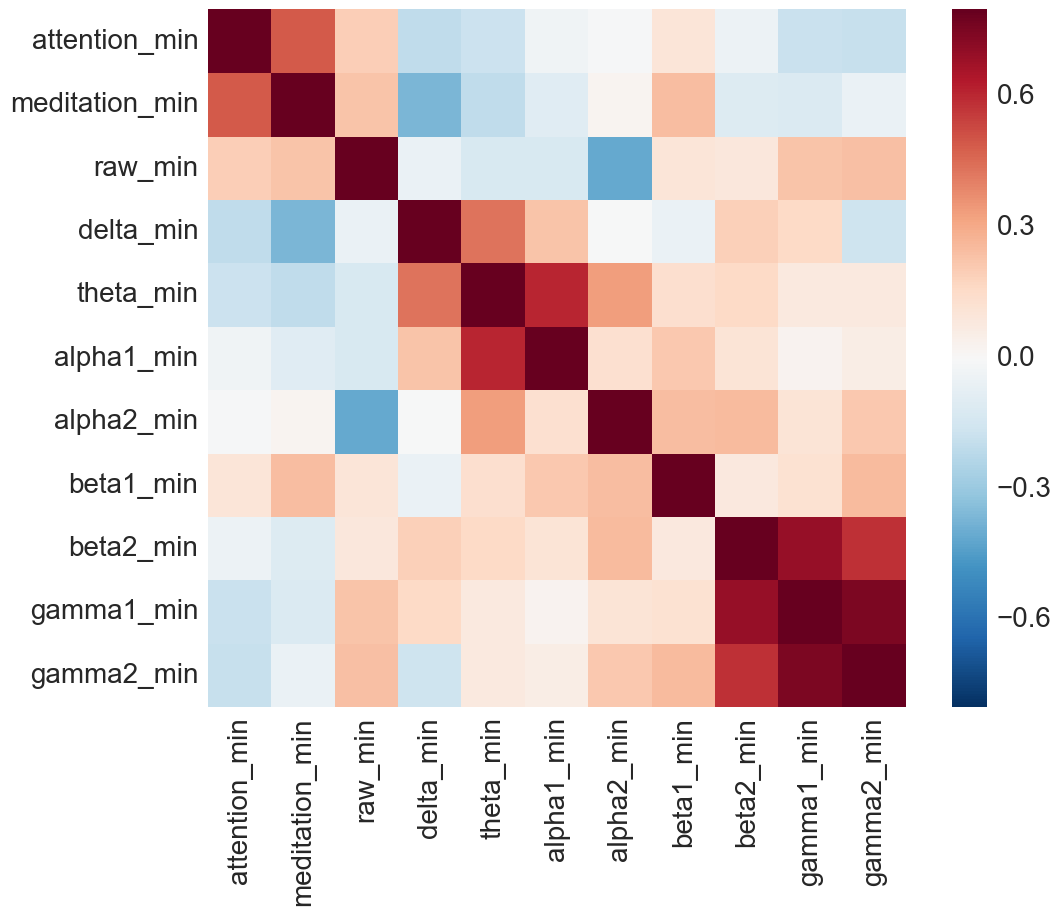

In [30]:
#min:
corrmat = features_grp[mn.columns].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn:
sns.set(font_scale=2)
sns.heatmap(corrmat, vmax=.8, square=True, label = 'large')

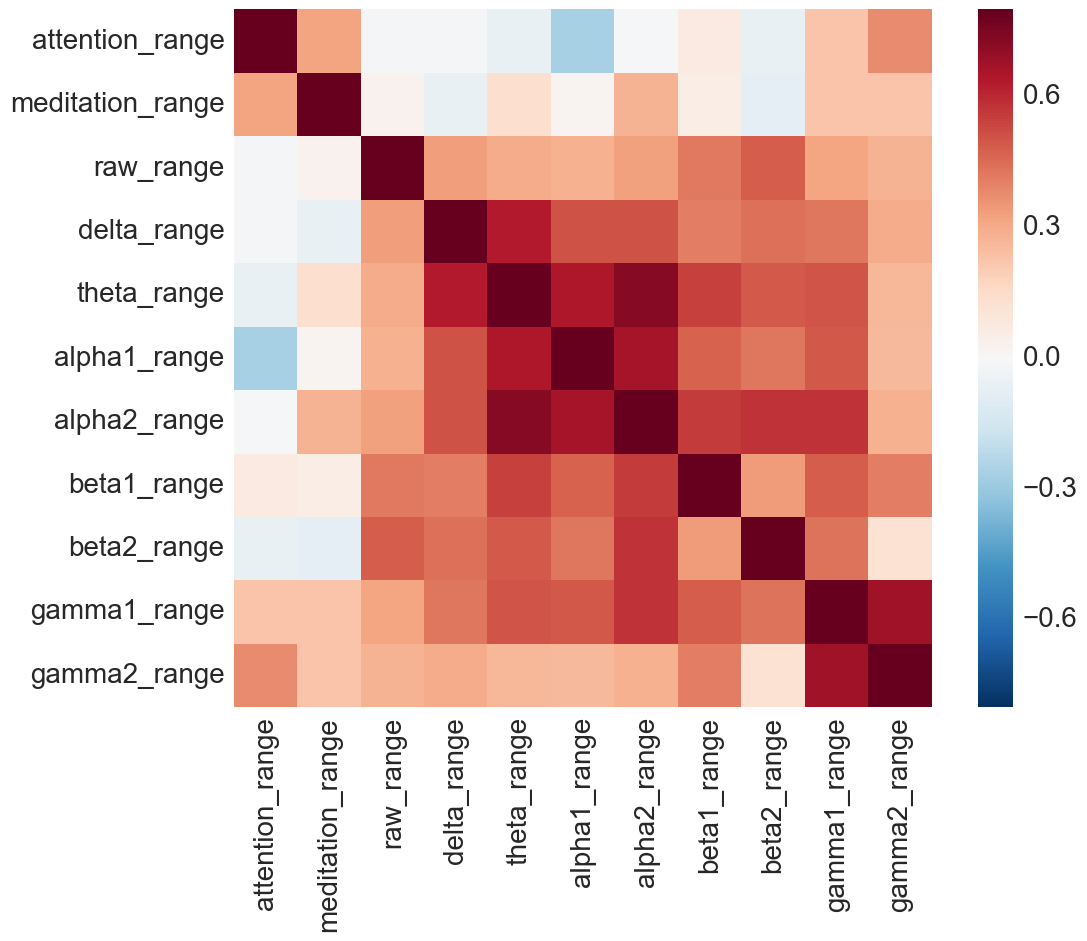

In [31]:
#range:
corrmat = features_grp[rng.columns].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn:
sns.set(font_scale=2)
sns.heatmap(corrmat, vmax=.8, square=True, label = 'large')

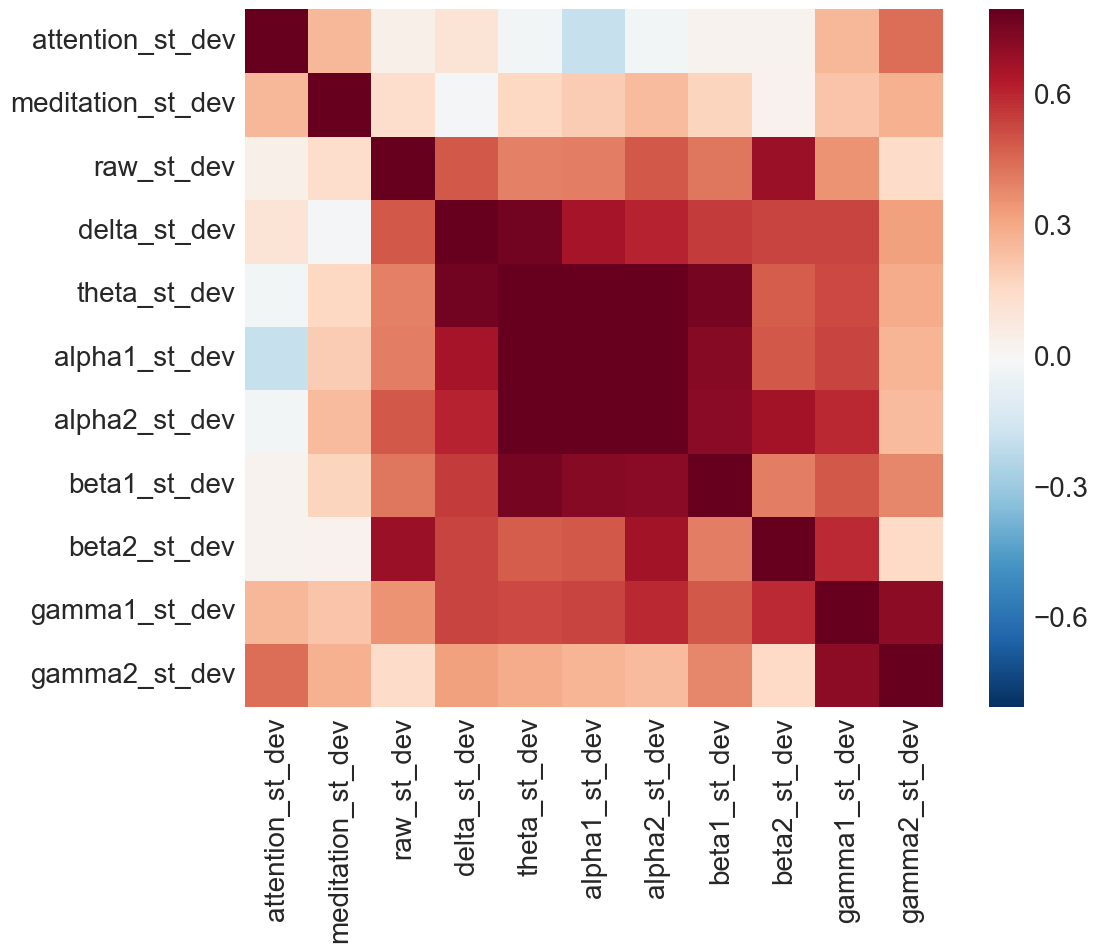

In [32]:
#standard deviation:
corrmat = features_grp[st_dev.columns].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn:
sns.set(font_scale=2)
sns.heatmap(corrmat, vmax=.8, square=True, label = 'large')

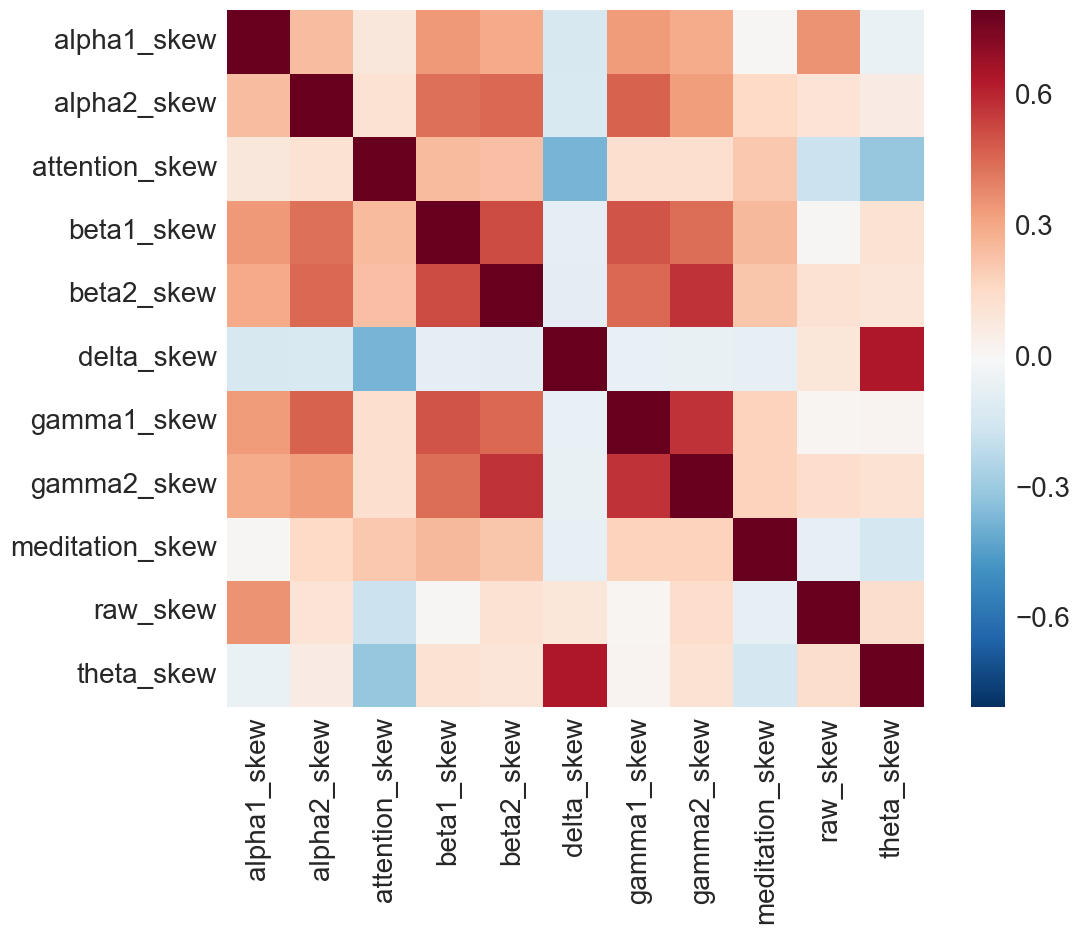

In [33]:
#skew:
corrmat = features_grp[skw.columns].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn:
sns.set(font_scale=2)
sns.heatmap(corrmat, vmax=.8, square=True, label = 'large')

### Test Different Subsets of the EEG features for confusion prediction accuracy:

In [135]:
from sklearn import tree, ensemble, svm, cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

### Testing on Decision Tree:

In [95]:
# dictionary of column groups:
collsts = {'mean': list(mns.columns), 
           'median': list(med.columns), 
           'max': list(mx.columns), 
           'min' : list(mn.columns), 
           'range' : list(rng.columns), 
           'st_dev': list(st_dev.columns), 
           'skew' : list(skw.columns)}

# dictionary to store results:
dt_scoreseval = {'mean': [], 'median': [], 'max': [], 'min' : [], 'range' : [], 'st_dev': [], 'skew' : []} 
dt_predseval = {'mean': [], 'median': [], 'max': [], 'min' : [], 'range' : [], 'st_dev': [], 'skew' : []} 
dt_featureeval = {'mean': [], 'median': [], 'max': [], 'min' : [], 'range' : [], 'st_dev': [], 'skew' : []} 

labelvals = labels['self-definedlabel'] # extract as a series so you don't get errors below.

for k, v in collsts.items():
    # get data for the metric set you want and build Decision Tree:
    
    X_features = features_grp[v].values
    X_features_df = features_grp[v]
    treeclf = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 10)
    treeclf = treeclf.fit(X_features, labelvals)
    #print('Feature Importances for %s:' % k)
    #print(' ')
    #print(v)
    #print(' ')
    #print(treeclf.feature_importances_)
    dt_featureeval[k] = treeclf.feature_importances_
    
    # initialize CV scores and predictions vectors:
    scores = list(range(90))
    
    # run 10-fold cross validation and save results
    for i in range(90):
        cv_scores = cross_validation.cross_val_score(treeclf, X_features, labelvals, cv = 10)
        scores[i] = cv_scores.mean()
    
    scores = np.array(scores)
    preds = cross_validation.cross_val_predict(treeclf, X_features, labelvals, cv = 10)
    
    # store results in scores and preds dictionaries:
    dt_scoreseval[k] = scores
    dt_predseval[k] = preds    

Feature Importances for range:
 
['attention_range', 'meditation_range', 'raw_range', 'delta_range', 'theta_range', 'alpha1_range', 'alpha2_range', 'beta1_range', 'beta2_range', 'gamma1_range', 'gamma2_range']
 
[ 0.14312998  0.06976262  0.          0.          0.0874646   0.05013007
  0.          0.23782162  0.04222634  0.05965579  0.30980898]
Feature Importances for st_dev:
 
['attention_st_dev', 'meditation_st_dev', 'raw_st_dev', 'delta_st_dev', 'theta_st_dev', 'alpha1_st_dev', 'alpha2_st_dev', 'beta1_st_dev', 'beta2_st_dev', 'gamma1_st_dev', 'gamma2_st_dev']
 
[ 0.          0.13521898  0.          0.09952536  0.24299679  0.          0.
  0.          0.25910959  0.08775335  0.17539593]
Feature Importances for min:
 
['attention_min', 'meditation_min', 'raw_min', 'delta_min', 'theta_min', 'alpha1_min', 'alpha2_min', 'beta1_min', 'beta2_min', 'gamma1_min', 'gamma2_min']
 
[ 0.16840623  0.17722025  0.          0.1738883   0.          0.          0.0541738
  0.24577065  0.          0.05

### Evaluate performance:

Average Accuracy based on mean:
Average accuracy of 0.73 with MOE of 0.04
Confusion Matrix based on mean:
[[28 16]
 [11 35]]
Classification Report based on mean:
             precision    recall  f1-score   support

          0       0.72      0.64      0.67        44
          1       0.69      0.76      0.72        46

avg / total       0.70      0.70      0.70        90



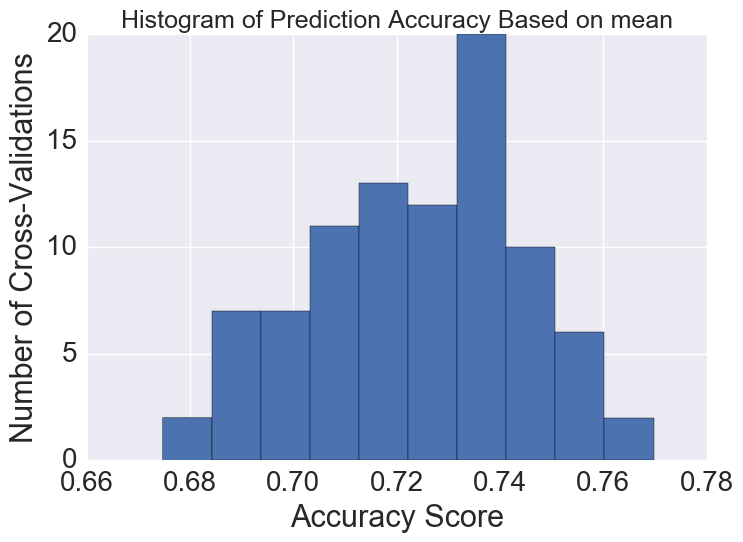

In [109]:
# means:
metric = 'mean'
dt_mean_cm = confusion_matrix(labelvals, dt_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (dt_scoreseval[metric].mean(), 2 * dt_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(dt_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, dt_predseval[metric]))

plt.hist(np.array(dt_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

Average Accuracy based on median:
Average accuracy of 0.84 with MOE of 0.02
Confusion Matrix based on median:
[[40  4]
 [10 36]]
Classification Report based on median:
             precision    recall  f1-score   support

          0       0.80      0.91      0.85        44
          1       0.90      0.78      0.84        46

avg / total       0.85      0.84      0.84        90



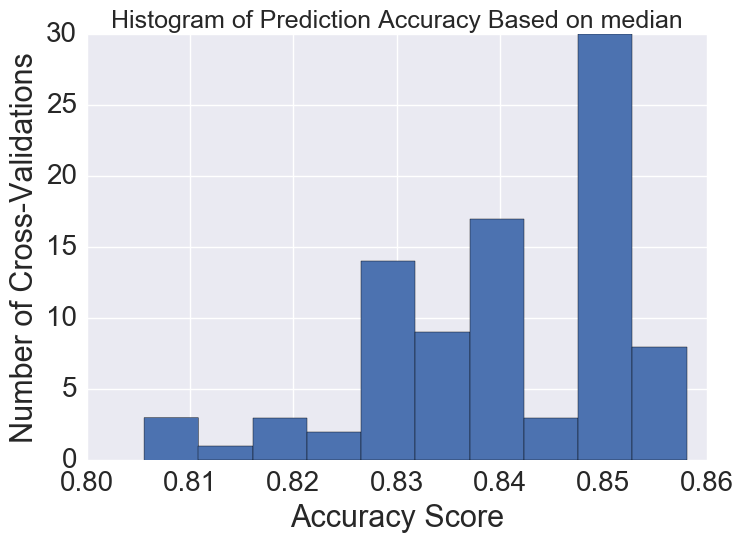

In [110]:
# medians:
metric = 'median'
dt_mean_cm = confusion_matrix(labelvals, dt_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (dt_scoreseval[metric].mean(), 2 * dt_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(dt_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, dt_predseval[metric]))

plt.hist(np.array(dt_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

Average Accuracy based on max:
Average accuracy of 0.58 with MOE of 0.03
Confusion Matrix based on max:
[[27 17]
 [21 25]]
Classification Report based on max:
             precision    recall  f1-score   support

          0       0.56      0.61      0.59        44
          1       0.60      0.54      0.57        46

avg / total       0.58      0.58      0.58        90



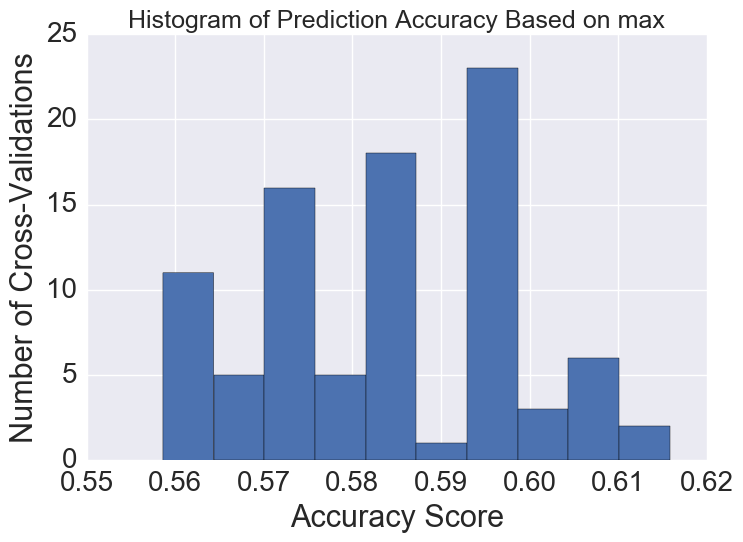

In [111]:
# maximum:
metric = 'max'
dt_mean_cm = confusion_matrix(labelvals, dt_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (dt_scoreseval[metric].mean(), 2 * dt_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(dt_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, dt_predseval[metric]))

plt.hist(np.array(dt_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

Average Accuracy based on min:
Average accuracy of 0.64 with MOE of 0.04
Confusion Matrix based on min:
[[30 14]
 [14 32]]
Classification Report based on min:
             precision    recall  f1-score   support

          0       0.68      0.68      0.68        44
          1       0.70      0.70      0.70        46

avg / total       0.69      0.69      0.69        90



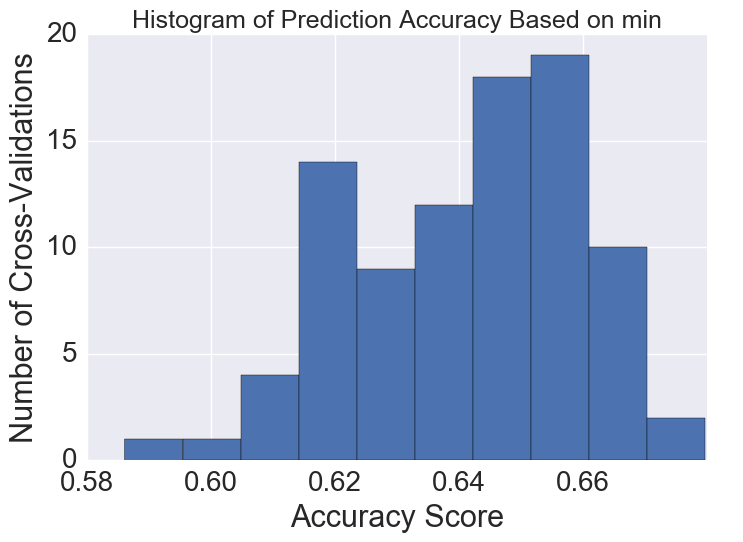

In [112]:
# minimum:
metric = 'min'
dt_mean_cm = confusion_matrix(labelvals, dt_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (dt_scoreseval[metric].mean(), 2 * dt_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(dt_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, dt_predseval[metric]))

plt.hist(np.array(dt_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

Average Accuracy based on range:
Average accuracy of 0.54 with MOE of 0.04
Confusion Matrix based on range:
[[21 23]
 [17 29]]
Classification Report based on range:
             precision    recall  f1-score   support

          0       0.55      0.48      0.51        44
          1       0.56      0.63      0.59        46

avg / total       0.56      0.56      0.55        90



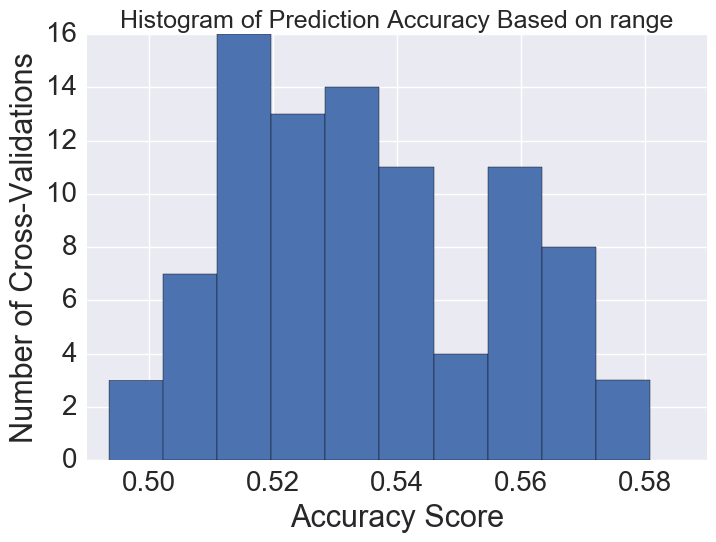

In [113]:
# range:
metric = 'range'
dt_mean_cm = confusion_matrix(labelvals, dt_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (dt_scoreseval[metric].mean(), 2 * dt_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(dt_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, dt_predseval[metric]))

plt.hist(np.array(dt_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

Average Accuracy based on st_dev:
Average accuracy of 0.61 with MOE of 0.05
Confusion Matrix based on st_dev:
[[30 14]
 [21 25]]
Classification Report based on st_dev:
             precision    recall  f1-score   support

          0       0.59      0.68      0.63        44
          1       0.64      0.54      0.59        46

avg / total       0.62      0.61      0.61        90



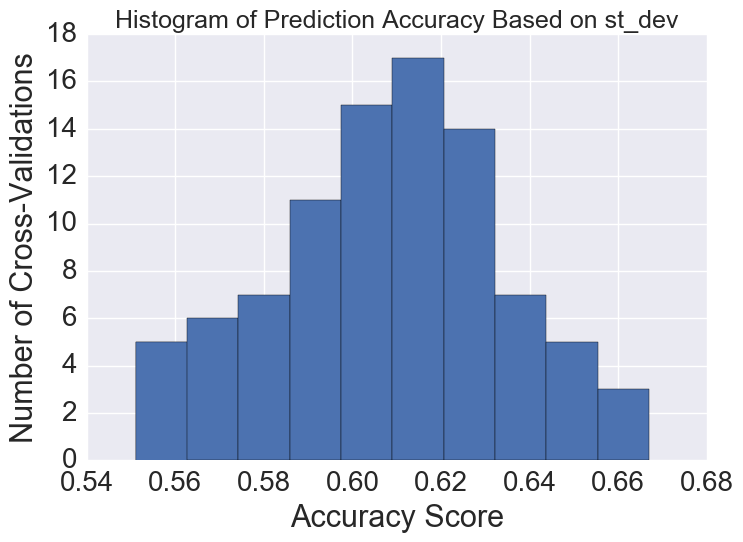

In [114]:
# st_dev:
metric = 'st_dev'
dt_mean_cm = confusion_matrix(labelvals, dt_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (dt_scoreseval[metric].mean(), 2 * dt_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(dt_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, dt_predseval[metric]))

plt.hist(np.array(dt_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

Average Accuracy based on skew:
Average accuracy of 0.57 with MOE of 0.04
Confusion Matrix based on skew:
[[28 16]
 [25 21]]
Classification Report based on skew:
             precision    recall  f1-score   support

          0       0.53      0.64      0.58        44
          1       0.57      0.46      0.51        46

avg / total       0.55      0.54      0.54        90



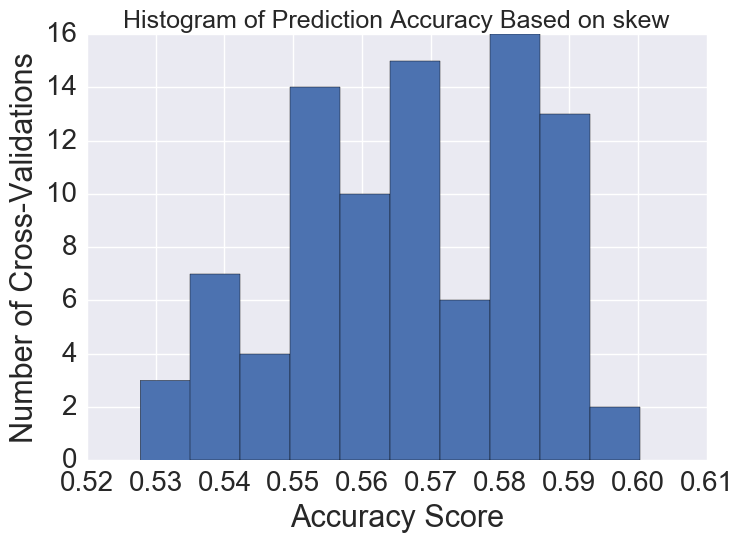

In [115]:
# skew:
metric = 'skew'
dt_mean_cm = confusion_matrix(labelvals, dt_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (dt_scoreseval[metric].mean(), 2 * dt_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(dt_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, dt_predseval[metric]))

plt.hist(np.array(dt_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

### Run through the same steps using Random Forest:

In [258]:
# dictionary to store results:
rf_scoreseval = {'mean': [], 'median': [], 'max': [], 'min' : [], 'range' : [], 'st_dev': [], 'skew' : []} 
rf_predseval = {'mean': [], 'median': [], 'max': [], 'min' : [], 'range' : [], 'st_dev': [], 'skew' : []}
rf_featureeval = {'mean': [], 'median': [], 'max': [], 'min' : [], 'range' : [], 'st_dev': [], 'skew' : []}

labelvals = labels['self-definedlabel'] # extract as a series so you don't get errors below.

for k, v in collsts.items():
    # get data for the metric set you want and build Decision Tree:
    
    X_features = features_grp[v].values
    X_features_df = features_grp[v]
    rfclf = ensemble.RandomForestClassifier(n_estimators=25, criterion='entropy', min_samples_split=10)
    rfclf = rfclf.fit(X_features, labelvals)
    #print('Feature Importances for %s:' % k)
    #print(' ')
    #print(v)
    #print(' ')
    #print(rfclf.feature_importances_)
    # store data on feature importances:
    rf_featureeval[k] = rfclf.feature_importances_
    
    # initialize CV scores and predictions vectors:
    scores = list(range(90))
    
    # run 10-fold cross validation and save results
    for i in range(90):
        cv_scores = cross_validation.cross_val_score(rfclf, X_features, labelvals, cv = 5)
        scores[i] = cv_scores.mean()
    
    scores = np.array(scores)
    preds = cross_validation.cross_val_predict(rfclf, X_features, labelvals, cv = 5)
    
    # store results in scores and preds dictionaries:
    rf_scoreseval[k] = scores
    rf_predseval[k] = preds

Average Accuracy based on mean:
Average accuracy of 0.75 with MOE of 0.06
Confusion Matrix based on mean:
[[37  7]
 [11 35]]
Classification Report based on mean:
             precision    recall  f1-score   support

          0       0.77      0.84      0.80        44
          1       0.83      0.76      0.80        46

avg / total       0.80      0.80      0.80        90



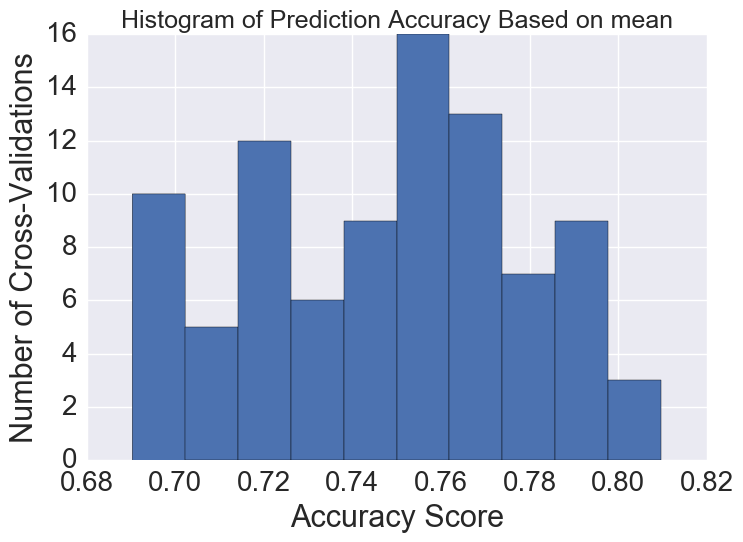

In [128]:
# means:
metric = 'mean'
rf_mean_cm = confusion_matrix(labelvals, rf_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (rf_scoreseval[metric].mean(), 2 * rf_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(rf_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, rf_predseval[metric]))

plt.hist(np.array(rf_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

Average Accuracy based on median:
Average accuracy of 0.72 with MOE of 0.06
Confusion Matrix based on median:
[[29 15]
 [10 36]]
Classification Report based on median:
             precision    recall  f1-score   support

          0       0.74      0.66      0.70        44
          1       0.71      0.78      0.74        46

avg / total       0.72      0.72      0.72        90



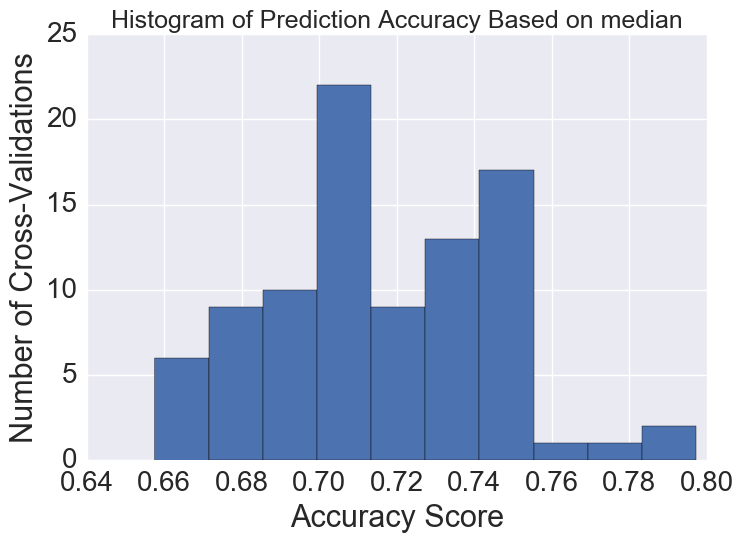

In [129]:
# median:
metric = 'median'
rf_mean_cm = confusion_matrix(labelvals, rf_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (rf_scoreseval[metric].mean(), 2 * rf_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(rf_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, rf_predseval[metric]))

plt.hist(np.array(rf_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

Average Accuracy based on max:
Average accuracy of 0.59 with MOE of 0.07
Confusion Matrix based on max:
[[29 15]
 [20 26]]
Classification Report based on max:
             precision    recall  f1-score   support

          0       0.59      0.66      0.62        44
          1       0.63      0.57      0.60        46

avg / total       0.61      0.61      0.61        90



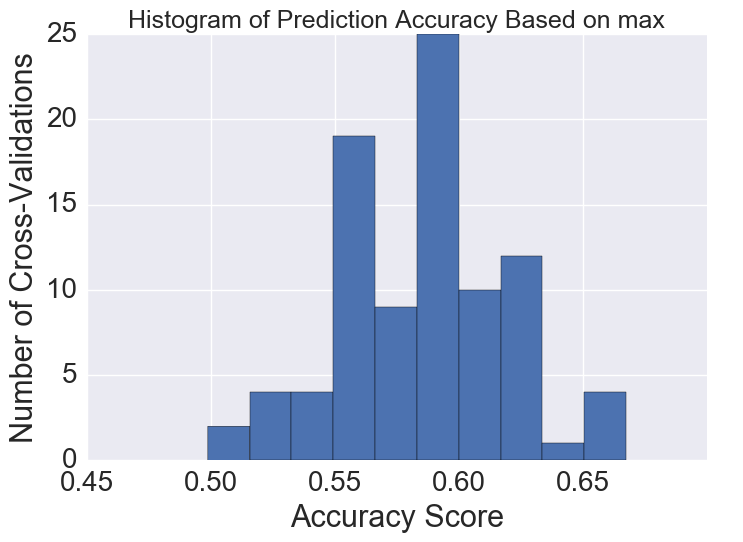

In [130]:
# max:
metric = 'max'
rf_mean_cm = confusion_matrix(labelvals, rf_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (rf_scoreseval[metric].mean(), 2 * rf_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(rf_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, rf_predseval[metric]))

plt.hist(np.array(rf_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

Average Accuracy based on min:
Average accuracy of 0.68 with MOE of 0.06
Confusion Matrix based on min:
[[30 14]
 [15 31]]
Classification Report based on min:
             precision    recall  f1-score   support

          0       0.67      0.68      0.67        44
          1       0.69      0.67      0.68        46

avg / total       0.68      0.68      0.68        90



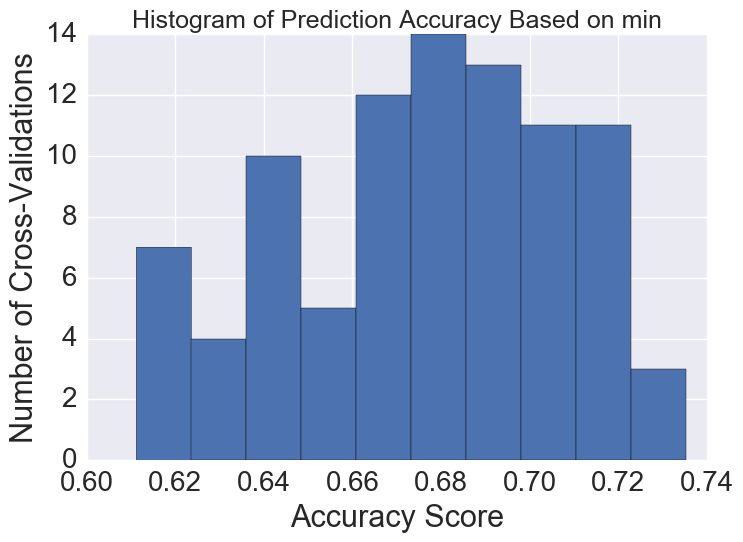

In [131]:
# min:
metric = 'min'
rf_mean_cm = confusion_matrix(labelvals, rf_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (rf_scoreseval[metric].mean(), 2 * rf_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(rf_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, rf_predseval[metric]))

plt.hist(np.array(rf_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

Average Accuracy based on range:
Average accuracy of 0.54 with MOE of 0.05
Confusion Matrix based on range:
[[22 22]
 [20 26]]
Classification Report based on range:
             precision    recall  f1-score   support

          0       0.52      0.50      0.51        44
          1       0.54      0.57      0.55        46

avg / total       0.53      0.53      0.53        90



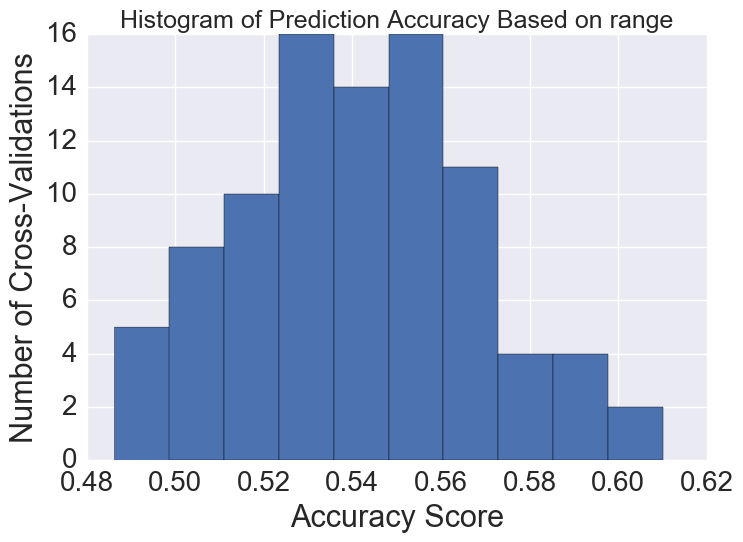

In [132]:
# range:
metric = 'range'
rf_mean_cm = confusion_matrix(labelvals, rf_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (rf_scoreseval[metric].mean(), 2 * rf_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(rf_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, rf_predseval[metric]))

plt.hist(np.array(rf_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

Average Accuracy based on st_dev:
Average accuracy of 0.60 with MOE of 0.05
Confusion Matrix based on st_dev:
[[22 22]
 [15 31]]
Classification Report based on st_dev:
             precision    recall  f1-score   support

          0       0.59      0.50      0.54        44
          1       0.58      0.67      0.63        46

avg / total       0.59      0.59      0.59        90



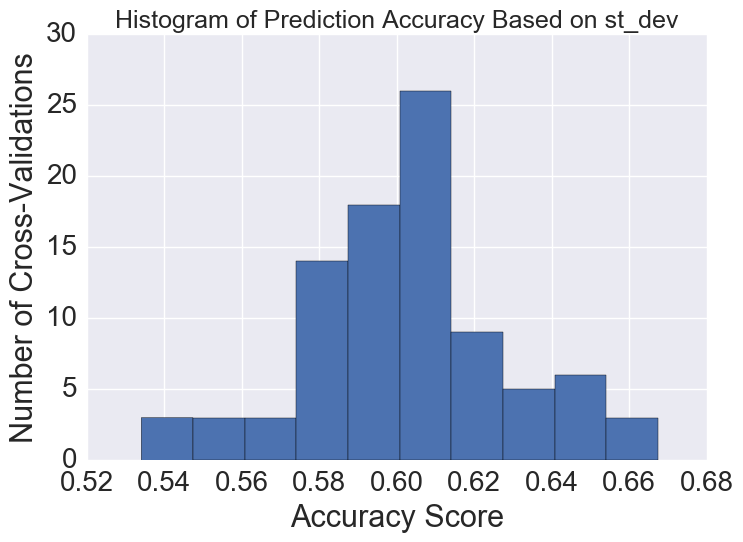

In [133]:
# st_dev:
metric = 'st_dev'
rf_mean_cm = confusion_matrix(labelvals, rf_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (rf_scoreseval[metric].mean(), 2 * rf_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(rf_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, rf_predseval[metric]))

plt.hist(np.array(rf_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

Average Accuracy based on skew:
Average accuracy of 0.58 with MOE of 0.07
Confusion Matrix based on skew:
[[26 18]
 [23 23]]
Classification Report based on skew:
             precision    recall  f1-score   support

          0       0.53      0.59      0.56        44
          1       0.56      0.50      0.53        46

avg / total       0.55      0.54      0.54        90



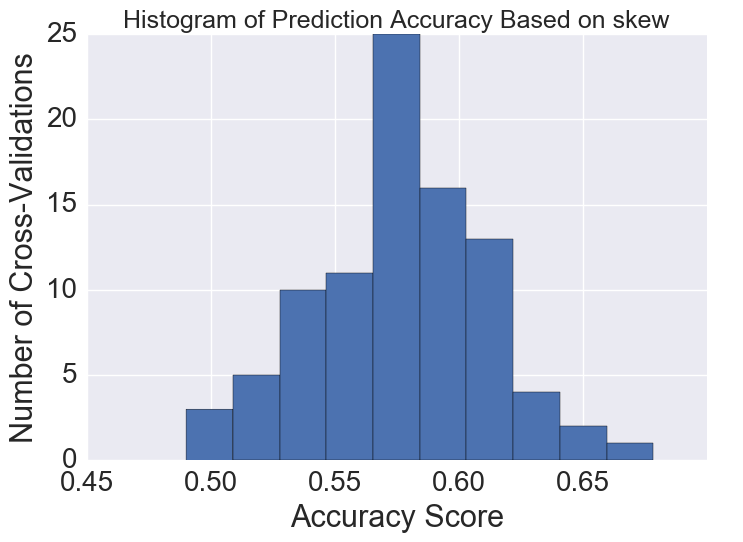

In [134]:
# skew:
metric = 'skew'
rf_mean_cm = confusion_matrix(labelvals, rf_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (rf_scoreseval[metric].mean(), 2 * rf_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(rf_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, rf_predseval[metric]))

plt.hist(np.array(rf_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

### Run again using SVM:

In [220]:
# dictionary to store results:
svm_scoreseval = {'mean': [], 'median': [], 'max': [], 'min' : [], 'range' : [], 'st_dev': [], 'skew' : []} 
svm_predseval = {'mean': [], 'median': [], 'max': [], 'min' : [], 'range' : [], 'st_dev': [], 'skew' : []}
svm_featureeval = {'mean': [], 'median': [], 'max': [], 'min' : [], 'range' : [], 'st_dev': [], 'skew' : []}

labelvals = labels['self-definedlabel'] # extract as a series so you don't get errors below.

for k, v in collsts.items():
    # get data for the metric set you want and build Decision Tree:
    
    X_features = features_grp[v].values.astype(float)
    X_features_df = features_grp[v]
    # scaling input variables (for SVM only):
    scaler = StandardScaler()
    X_features = scaler.fit_transform(X_features)
    svmclf = svm.SVC(kernel='poly', C=1.0, gamma = 0.1)
    svmclf = rfclf.fit(X_features, labelvals)
    
    # initialize CV scores and predictions vectors:
    scores = list(range(90))
    
    # run 10-fold cross validation and save results
    for i in range(90):
        cv_scores = cross_validation.cross_val_score(svmclf, X_features, labelvals, cv = 5)
        scores[i] = cv_scores.mean()
    
    scores = np.array(scores)
    preds = cross_validation.cross_val_predict(svmclf, X_features, labelvals, cv = 5)
    
    # store results in scores and preds dictionaries:
    svm_scoreseval[k] = scores
    svm_predseval[k] = preds

Average Accuracy based on mean:
Average accuracy of 0.75 with MOE of 0.06
Confusion Matrix based on mean:
[[33 11]
 [13 33]]
Classification Report based on mean:
             precision    recall  f1-score   support

          0       0.72      0.75      0.73        44
          1       0.75      0.72      0.73        46

avg / total       0.73      0.73      0.73        90



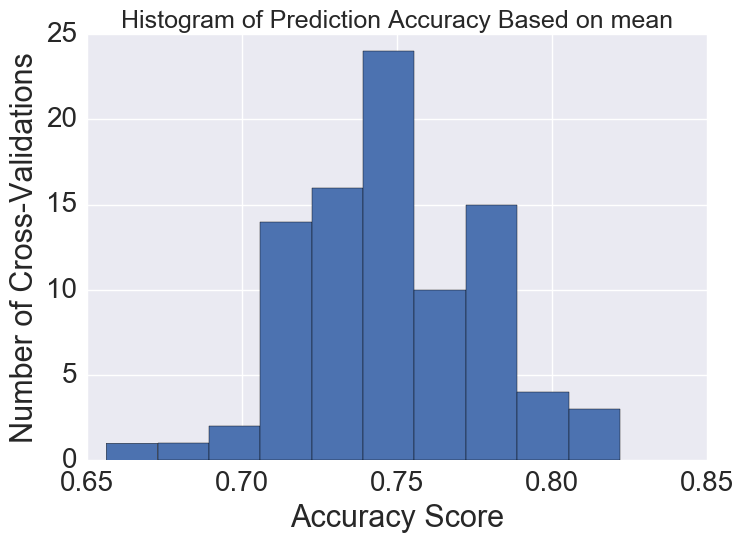

In [206]:
# means:
metric = 'mean'
svm_mean_cm = confusion_matrix(labelvals, svm_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (svm_scoreseval[metric].mean(), 2 * svm_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(svm_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, svm_predseval[metric]))

plt.hist(np.array(svm_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

Average Accuracy based on median:
Average accuracy of 0.72 with MOE of 0.06
Confusion Matrix based on median:
[[29 15]
 [13 33]]
Classification Report based on median:
             precision    recall  f1-score   support

          0       0.69      0.66      0.67        44
          1       0.69      0.72      0.70        46

avg / total       0.69      0.69      0.69        90



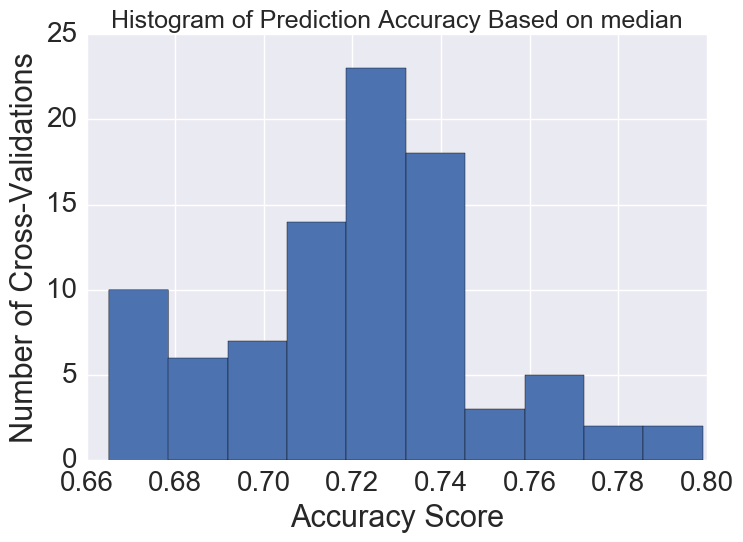

In [207]:
# median:
metric = 'median'
svm_mean_cm = confusion_matrix(labelvals, svm_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (svm_scoreseval[metric].mean(), 2 * svm_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(svm_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, svm_predseval[metric]))

plt.hist(np.array(svm_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

Average Accuracy based on max:
Average accuracy of 0.59 with MOE of 0.06
Confusion Matrix based on max:
[[25 19]
 [18 28]]
Classification Report based on max:
             precision    recall  f1-score   support

          0       0.58      0.57      0.57        44
          1       0.60      0.61      0.60        46

avg / total       0.59      0.59      0.59        90



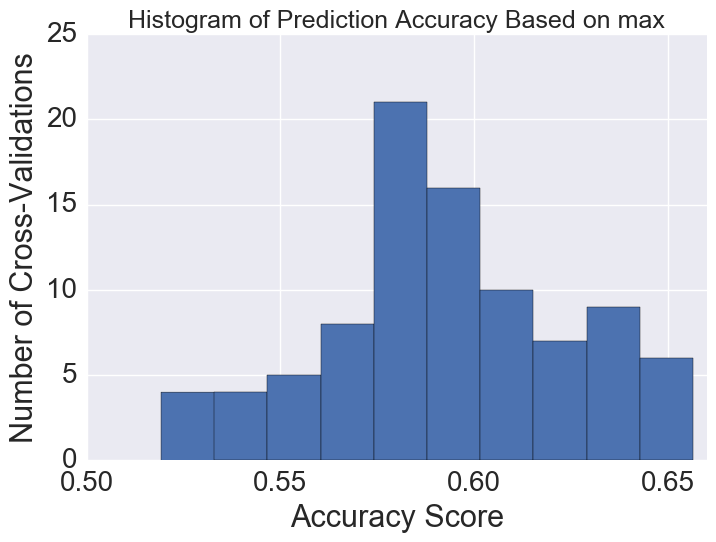

In [208]:
# max:
metric = 'max'
svm_mean_cm = confusion_matrix(labelvals, svm_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (svm_scoreseval[metric].mean(), 2 * svm_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(svm_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, svm_predseval[metric]))

plt.hist(np.array(svm_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

Average Accuracy based on min:
Average accuracy of 0.68 with MOE of 0.05
Confusion Matrix based on min:
[[29 15]
 [12 34]]
Classification Report based on min:
             precision    recall  f1-score   support

          0       0.71      0.66      0.68        44
          1       0.69      0.74      0.72        46

avg / total       0.70      0.70      0.70        90



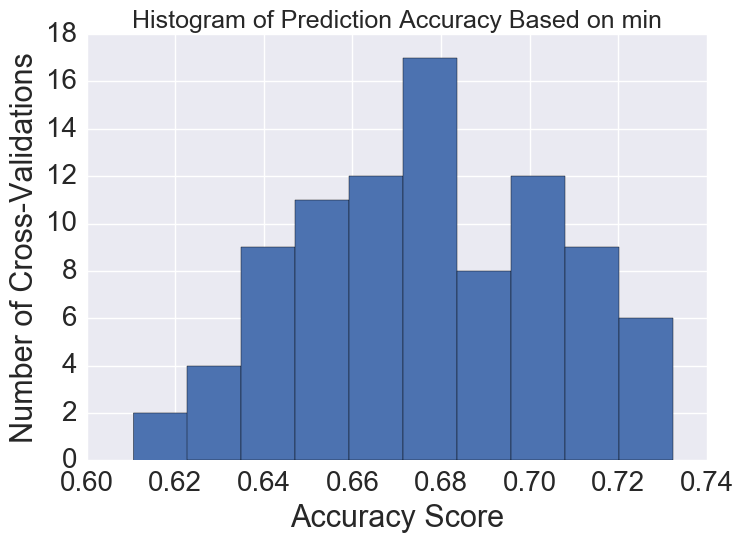

In [209]:
# min:
metric = 'min'
svm_mean_cm = confusion_matrix(labelvals, svm_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (svm_scoreseval[metric].mean(), 2 * svm_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(svm_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, svm_predseval[metric]))

plt.hist(np.array(svm_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

Average Accuracy based on range:
Average accuracy of 0.54 with MOE of 0.06
Confusion Matrix based on range:
[[20 24]
 [15 31]]
Classification Report based on range:
             precision    recall  f1-score   support

          0       0.57      0.45      0.51        44
          1       0.56      0.67      0.61        46

avg / total       0.57      0.57      0.56        90



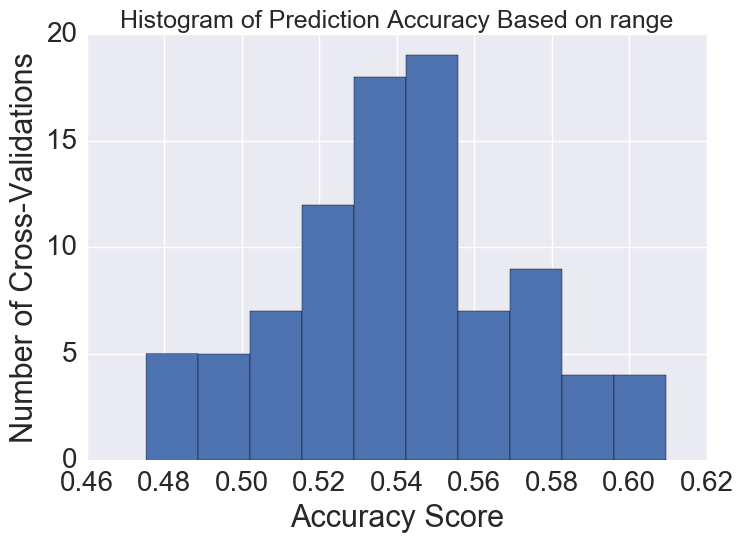

In [210]:
# range:
metric = 'range'
svm_mean_cm = confusion_matrix(labelvals, svm_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (svm_scoreseval[metric].mean(), 2 * svm_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(svm_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, svm_predseval[metric]))

plt.hist(np.array(svm_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

Average Accuracy based on st_dev:
Average accuracy of 0.61 with MOE of 0.06
Confusion Matrix based on st_dev:
[[26 18]
 [20 26]]
Classification Report based on st_dev:
             precision    recall  f1-score   support

          0       0.57      0.59      0.58        44
          1       0.59      0.57      0.58        46

avg / total       0.58      0.58      0.58        90



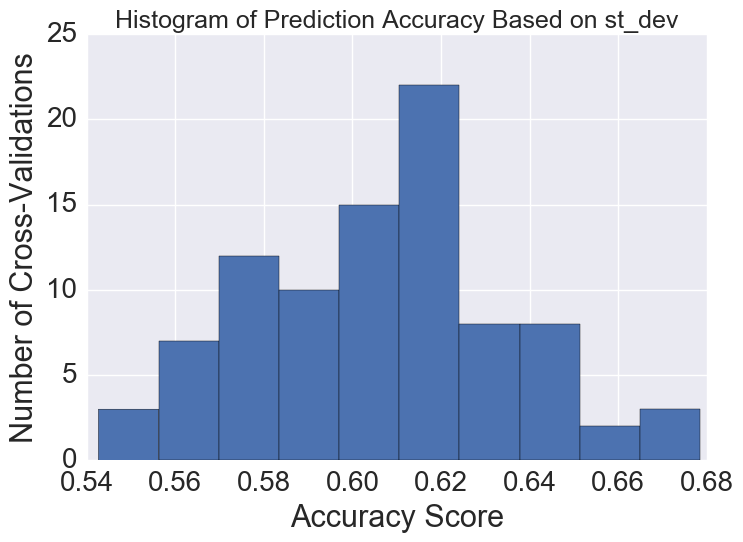

In [211]:
# st_dev:
metric = 'st_dev'
svm_mean_cm = confusion_matrix(labelvals, svm_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (svm_scoreseval[metric].mean(), 2 * svm_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(svm_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, svm_predseval[metric]))

plt.hist(np.array(svm_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

Average Accuracy based on skew:
Average accuracy of 0.58 with MOE of 0.07
Confusion Matrix based on skew:
[[26 18]
 [22 24]]
Classification Report based on skew:
             precision    recall  f1-score   support

          0       0.54      0.59      0.57        44
          1       0.57      0.52      0.55        46

avg / total       0.56      0.56      0.56        90



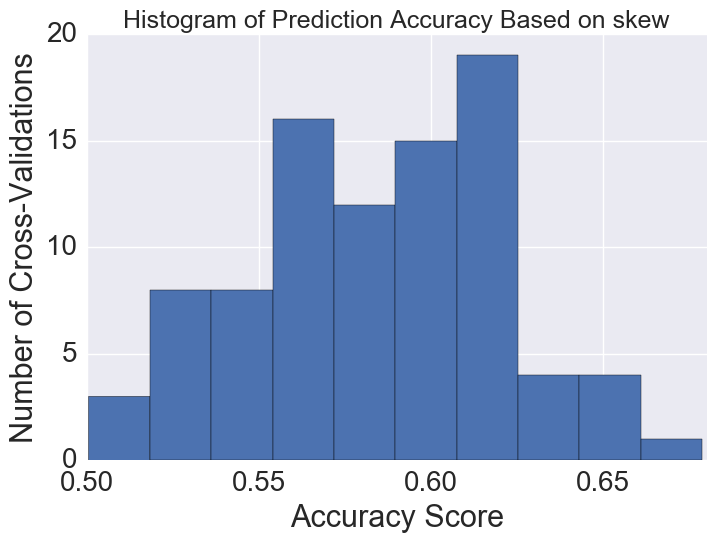

In [212]:
# skew:
metric = 'skew'
svm_mean_cm = confusion_matrix(labelvals, svm_predseval[metric])
print('Average Accuracy based on %s:' % metric)
print('Average accuracy of %0.2f with MOE of %0.2f' % (svm_scoreseval[metric].mean(), 2 * svm_scoreseval[metric].std()))
print('Confusion Matrix based on %s:' % metric)
print(svm_mean_cm)
print('Classification Report based on %s:' % metric)
print(classification_report(labelvals, svm_predseval[metric]))

plt.hist(np.array(svm_scoreseval[metric]))
plt.title('Histogram of Prediction Accuracy Based on %s' % metric, size = 18)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Cross-Validations')

### Random Forest Run on all Features at once:

In [188]:
# dictionary to store results:
rf_scoreseval = {'all': []} 
rf_predseval = {'all': []} 
rf_featureeval = {'all': []} 

labelvals = labels['self-definedlabel'] # extract as a series so you don't get errors below.

X_features = features_grp.values
X_features_df = features_grp
rfclf = ensemble.RandomForestClassifier(n_estimators=25, criterion='entropy', min_samples_split=10)
rfclf = rfclf.fit(X_features, labelvals)

rf_featureeval['all'] = rfclf.feature_importances_
sortedimps = np.argsort(np.array(rf_featureeval['all']))
rf_featurenames = np.array(X_features_df.columns)

scores = list(range(90))

for i in range(90):
    cv_scores = cross_validation.cross_val_score(rfclf, X_features, labelvals, cv = 5)
    scores[i] = cv_scores.mean()

scores = np.array(scores)
preds = cross_validation.cross_val_predict(rfclf, X_features, labelvals, cv = 5)

rf_scoreseval[k] = scores
rf_predseval[k] = preds

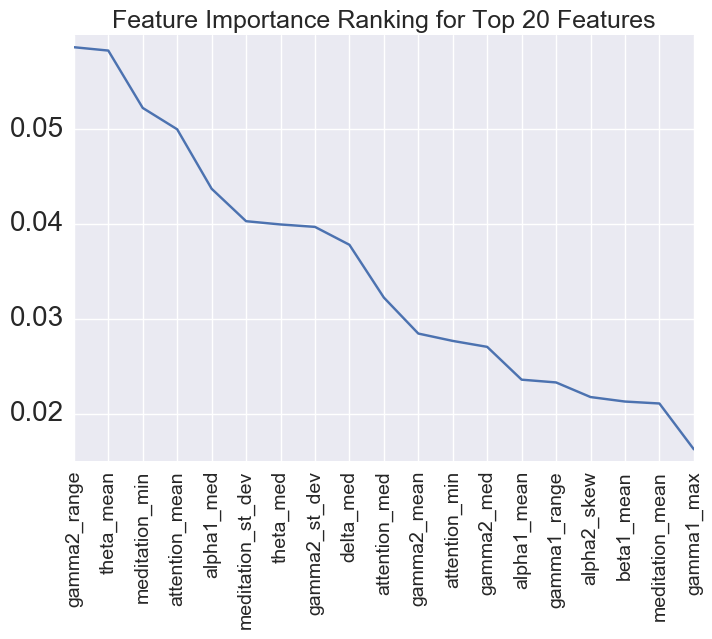

In [248]:
#rf_featureeval['all']
lst = list(rf_featurenames[sortedimps])
lst = lst[::-1]

y = rf_featureeval['all'][sortedimps][::-1]
#plt.plot(y[0:30])
#plt.x


fig, ax = plt.subplots()

# We need to draw the canvas, otherwise the labels won't be positioned and 
# won't have values yet.
fig.canvas.draw()

labels = [item for item in lst[0:19]]
plt.xticks(np.arange(19))
ax.set_xticklabels(labels, size = 14, rotation = 'vertical')
plt.plot(y[0:19])
plt.title('Feature Importance Ranking for Top 20 Features', size = 18)

plt.show()



### Build Evaluation Tables:

In [274]:
# decision tree:
dtdf = pd.DataFrame(dt_scoreseval)
#dtdf.rename(columns = lambda x: x + '_dtree', inplace = True)

# svm:
svmdf = pd.DataFrame(svm_scoreseval)
#svmdf.rename(columns = lambda x: x + '_svm', inplace = True)

# random forest:
rfdf = pd.DataFrame(rf_scoreseval)
#rfdf.rename(columns = lambda x: x + '_rf', inplace = True)

dt_sum = pd.concat([dtdf.mean(), dtdf.std()], axis = 1)
dt_sum.rename(columns = {0 : 'mean', 1: 'st_dev'}, inplace = True)
dt_sum['model'] = 'Decision Tree'

svm_sum = pd.concat([svmdf.mean(), svmdf.std()], axis = 1)
svm_sum.rename(columns = {0 : 'mean', 1: 'st_dev'}, inplace = True)
svm_sum['model'] = 'Support Vector Machine'

rf_sum = pd.concat([rfdf.mean(), rfdf.std()], axis = 1)
rf_sum.rename(columns = {0 : 'mean', 1: 'st_dev'}, inplace = True)
rf_sum['model'] = 'Random Forest'

pd.concat([dt_sum, svm_sum, rf_sum])


,mean,st_dev,model
max,0.583593,0.014013,Decision Tree
mean,0.725333,0.022296,Decision Tree
median,0.839333,0.012023,Decision Tree
min,0.641102,0.018544,Decision Tree
range,0.535019,0.022320,Decision Tree
skew,0.566861,0.017955,Decision Tree
st_dev,0.608806,0.027340,Decision Tree
max,0.590181,0.028784,Support Vector Machine
mean,0.755072,0.031228,Support Vector Machine
median,0.724130,0.033598,Support Vector Machine
